# Github comments sentiment analysis

- Option 1: Use [Detoxify model](https://github.com/unitaryai/detoxify)
- Option 2: Use LLM based toxicity assessment
- Option 3: Use multi-step LLM assessment

In [23]:
import os
from pathlib import Path

import pandas as pd
from dotenv import load_dotenv
from tinydb import Query, TinyDB
from tqdm import tqdm

from openowl.clients import OpenOwlClient
from openowl.gh_llm import get_issue_summarization
from openowl.gh_sentiment_analysis import get_toxicity_scores
from openowl.logger_config import setup_logger
from openowl.utils import extract_github_info, sort_version_list

logger = setup_logger(__name__)
load_dotenv()

True

In [27]:
# Functions

#TODO implement this and add summary to issues table
def summarize_issues(issues_table, default_model):
    """Summarize issues in database."""
    for issue in issues_table.all():
        issue_summarization = get_issue_summarization(
            issue,
            default_model,
        )
        issue["issue_summarization"] = issue_summarization
        issues_table.upsert(issue, Query().id == issue["id"])

    from urllib.parse import urlparse


In [13]:
PROJECT_ROOT = Path().absolute().parent

In [ ]:
# Define package info
package_manager="pypi"
github_url="https://github.com/pandas-dev/pandas"
package_version=None
debug=True

# extract package info from github url
package_owner, package_name = extract_github_info(github_url)

# if no version is provided, get latest version
if package_version is None:
    oowl_client = OpenOwlClient()
    package_versions = oowl_client.get_package_versions(
        package_manager, package_name
    )
    package_versions = sort_version_list(package_versions)
    package_version = package_versions[0]
    logger.info(f"No version provided, took the latest version: {package_version}")

dependency = {
    "package_manager": package_manager,
    "owner": package_owner,
    "name": package_name,
    "version": package_version,
}

# Initialize/load TinyDB
if PROJECT_ROOT:
    db = TinyDB(Path(PROJECT_ROOT / os.environ.get("PATH_DB")))
else:
    db = TinyDB(Path(os.environ.get("PATH_DB")))
dependencies_table = db.table("dependencies")
issues_table = db.table("issues")
issue_dependency_table = db.table("issue_dependency")

## Option 1: Use Detoxify model

- We use the [Detoxify model "original"](https://github.com/unitaryai/detoxify) to assess the toxicity of the comments.

In [15]:
# get toxicity scores, add them to the issues table and obtain dataframe
comments_df = get_toxicity_scores(issues_table)

Analyzing comment toxicity:   0%|          | 0/78 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Analyzing comment toxicity: 100%|██████████| 78/78 [00:04<00:00, 17.01it/s]


In [26]:
print(f"Number of comments: {len(comments_df)}")

comments_df['datetime'] = pd.to_datetime(comments_df['datetime'])
print(f"Time range: {comments_df['datetime'].min().strftime(
    '%Y-%m-%d %H:%M')} to {comments_df['datetime'].max().strftime('%Y-%m-%d %H:%M')}")

Number of comments: 78
Time range: 2024-12-01 13:05 to 2024-12-08 05:58


In [17]:
comments_df.head()

,datetime,issue_id,comment_details,author_association,user,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
43,2024-12-01T13:05:40Z,2709132946,## [CodSpeed Performance Report](https://codsp...,NONE,codspeed-hq[bot],0.000805,0.000107,0.000187,0.000113,0.000178,0.000136
44,2024-12-01T13:08:37Z,2709132946,"## Coverage report\n\n\n<img title=""Coverage f...",CONTRIBUTOR,github-actions[bot],0.001093,0.000105,0.000222,0.000114,0.000185,0.000137
45,2024-12-01T14:47:25Z,2709132946,please review (and thank you ❤️ ),NONE,thejcannon,0.000547,0.000132,0.000187,0.000135,0.000175,0.000142
46,2024-12-01T19:04:06Z,2709128734,Thanks for the report. While we can accept the...,MEMBER,Viicos,0.000696,0.000118,0.000199,0.000115,0.000172,0.000138
47,2024-12-01T19:14:37Z,2709128734,> We first generate the JSON Schema for the in...,NONE,thejcannon,0.000739,0.000115,0.000189,0.000120,0.000176,0.000139


<Axes: xlabel='datetime'>

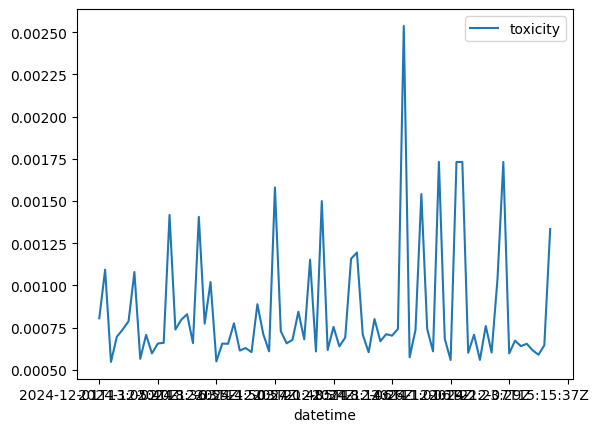

In [18]:
# plot toxicity over time
comments_df.plot(kind="line", x="datetime", y="toxicity")

In [ ]:
# threshold for toxic comments
comments_df["is_toxic"] = comments_df["toxicity"] > 0.04



## Option 2: Use LLM based toxicity assessment